In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

%cd C247_Project
%ls -a

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/C247_Project
 AngleEstimationTutorial.ipynb   dichasus/   models/              utils/
'Dataset Links.gdoc'             doatools/  'Papers from IEEE'/
 Data_Sets/                      .git/       rad_sdk/


In [2]:
import numpy as np
import doatools.model as model
from doatools.plotting import plot_array, plot_coarray
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from utils.dichasusAoAFunctions import *
from models.AOA_CNN import *
from models.AOA_RNN import *
from models.AOA_NN import *
from utils.Dichacus_Antenna_Cal import *

In [3]:
datafiles = ["dichasus/dichasus-0152.tfrecords", "dichasus/dichasus-0153.tfrecords"]
dataset = tf.data.TFRecordDataset(datafiles).map(record_parse_function)
Antenna_Array = Dichacus_Antenna_Cal("dichasus/reftx-offsets-dichasus-015x.json")

training_set = dataset.filter(lambda csi, pos, angle, dist, csi_complex, cov: dist <= 4 and dist > 0.5)
test_set = dataset.filter(lambda csi, pos, angle, dist, csi_complex, cov: dist > 4)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [4]:
training_set_features = training_set.map(get_feature_mapping(32))
test_set_features = test_set.map(get_feature_mapping(32))

training_set_features = training_set_features.shuffle(buffer_size = 100000).cache()
test_set_features = test_set_features.shuffle(buffer_size = 100000).cache()

In [5]:
model = AOA_CNN(input_dim = (32,32,2), num_activation_layers=2,activation_function="relu")
#model2 = AOA_CNN(input_dim = (32,32,2), num_activation_layers=2,activation_function="relu")

batch_sizes = [32, 64, 256, 1024, 4096]
batch_sizes = [256]
for b in batch_sizes:
	model.train(training_set_features, test_set_features, batch_size= b, use_cov=True, epochs_in = 50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        608       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       120       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 15, 15, 64)       6

In [6]:
test_outputs = model.test(test_set_features, use_cov=True)
# test_outputs_2 = model2.test(test_set_features)

2/2 [==============================] - 0s 69ms/step


In [7]:
from models.MUSIC_AOA import *
import doatools.model as doamodel
import doatools.estimation as estimation

d0 = 0.118
ura = doamodel.UniformRectangularArray(4,8, d0)
# ura = doamodel.UniformLinearArray(32, d0)
# grid = estimation.FarField1DSearchGrid(start=-np.pi/4, stop=np.pi/4)
grid = estimation.FarField1DSearchGrid()
test_outputs_2 = {}

SNR = []
predicted_angles = []
true_angles = []

estimator = estimation.MUSIC(ura, d0*2, grid)

for csi, pos, angle, dist, complex_csi, Ry in test_set_features.batch(1):
    resolved, estimates = estimator.estimate(convertIqArray2complex(Ry.numpy()[0,:,:,:]), 1)
    if resolved:
        # SNR.append(snr.numpy())
        true_angles.append(angle.numpy())
        predicted_angles.append(estimates.locations)

# SNR = np.hstack(SNR)
predicted_angles = np.hstack(predicted_angles)
true_angles = np.hstack(true_angles)
errors_abs_deg = np.rad2deg(np.abs(true_angles - predicted_angles))

test_outputs_2['predictedangles'] = predicted_angles
test_outputs_2['true_angles'] = true_angles
# test_outputs_2['SNR'] = SNR
test_outputs_2['errors_abs_deg'] = errors_abs_deg

In [14]:
tmp_positions, tmp_predicted = Antenna_Array.estimate_angles(test_set_features, 512, 520, 1.272e9, 50e6)

tmp_true_angles = np.arctan2(-tmp_positions[:,1], -tmp_positions[:,0] + 0.2)
tmp_error_abs_degrees = np.rad2deg(np.abs(tmp_predicted - tmp_true_angles))

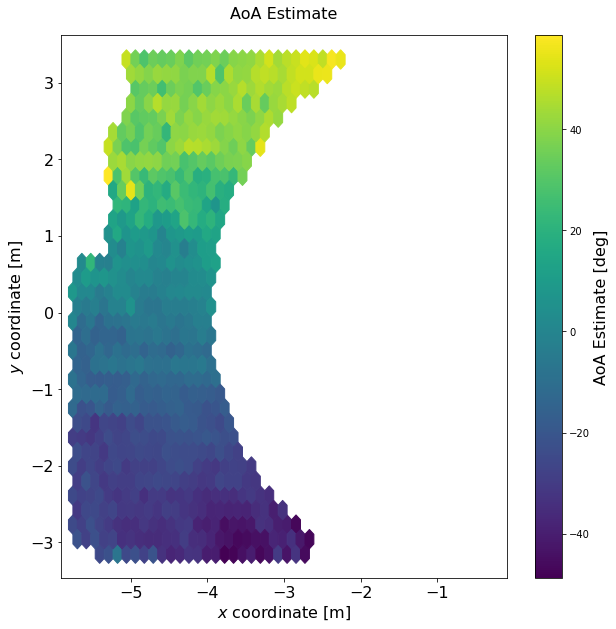

In [15]:
positions = test_outputs['positions']
predicted_angles = test_outputs['predictedangles']
true_angles = test_outputs['true_angles']
positions = test_outputs['distances']
errorvectors = test_outputs['errorvectors']
errors_abs_deg = test_outputs['errors_abs_deg'] 

# positions2 = test_outputs_2['positions']
predicted_angles2 = test_outputs_2['predictedangles']
true_angles2 = test_outputs_2['true_angles']
#positions2 = test_outputs_2['distances']
#errorvectors2 = test_outputs_2['errorvectors']
errors_abs_deg2 = test_outputs_2['errors_abs_deg'] 
# ML_Estimates = np.concatenate(ML_Estimates)
# errors_abs_deg_ML = np.rad2deg(np.abs(true_angles - ML_Estimates))
# errors_abs_deg_2 = np.rad2deg(np.abs(true_angles - angle_estimates_test))
plt.figure(figsize=(10, 10))
plt.title("AoA Estimate", fontsize = 16, pad = 16)

plt.axis("equal")
plt.xlim(-6, 0)
plt.hexbin(x = positions[:, 0], y = positions[:, 1], C = np.rad2deg(predicted_angles), gridsize = 30)
cb = plt.colorbar()
cb.set_label("AoA Estimate [deg]", fontsize = 16)
plt.xlabel("$x$ coordinate [m]", fontsize = 16)
plt.ylabel("$y$ coordinate [m]", fontsize = 16)
plt.tick_params(axis = "both", labelsize = 16)
plt.show()

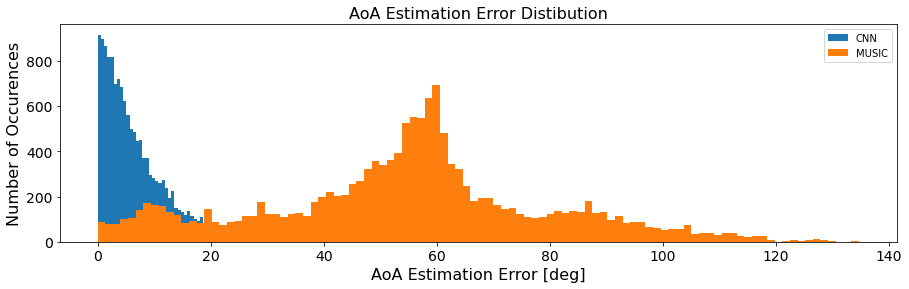

In [16]:
plt.figure(figsize=(15, 4))
plt.title("AoA Estimation Error Distibution", fontsize = 16)
plt.xlabel("AoA Estimation Error [deg]", fontsize = 16)
plt.ylabel("Number of Occurences", fontsize = 16)
plt.tick_params(axis = "both", labelsize = 14)

# true_angles = np.arctan2(-positions_train[:,1], -positions_train[:,0] + 0.2)
# est_error_train = np.abs(np.rad2deg(np.angle(np.exp(1.0j * angle_estimates_train) * np.conj(np.exp(1.0j * true_angles)))))

# true_angles = np.arctan2(-positions_test[:,1], -positions_test[:,0] + 0.2)
# est_error_test = np.abs(np.rad2deg(np.angle(np.exp(1.0j * angle_estimates_test) * np.conj(np.exp(1.0j * true_angles)))))
		
plt.hist(errors_abs_deg, bins = 100, label = "CNN")
# plt.hist(est_error_train, bins = 100, label = "Train")
plt.hist(errors_abs_deg2, bins = 100, label = "MUSIC")
plt.legend()
plt.show()

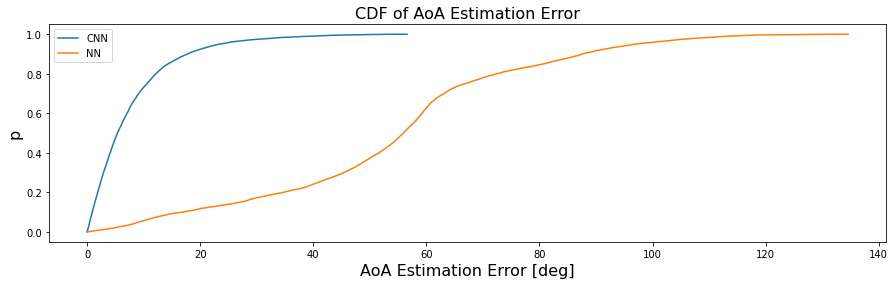

In [17]:
data_sorted = np.sort(errors_abs_deg)

# calculate the proportional values of samples
p = 1. * np.arange(len(data_sorted)) / (len(data_sorted) - 1)

data_sorted_ML = np.sort(errors_abs_deg2)

# calculate the proportional values of samples
p_ml = 1. * np.arange(len(data_sorted_ML)) / (len(data_sorted_ML) - 1)

plt.figure(figsize=(15, 4))
plt.title("CDF of AoA Estimation Error", fontsize = 16)
plt.xlabel("AoA Estimation Error [deg]", fontsize = 16)
plt.ylabel("p", fontsize = 16)
		
plt.plot(data_sorted, p, label = "CNN")
plt.plot(data_sorted_ML, p_ml, label = "NN")
plt.legend()
plt.show()

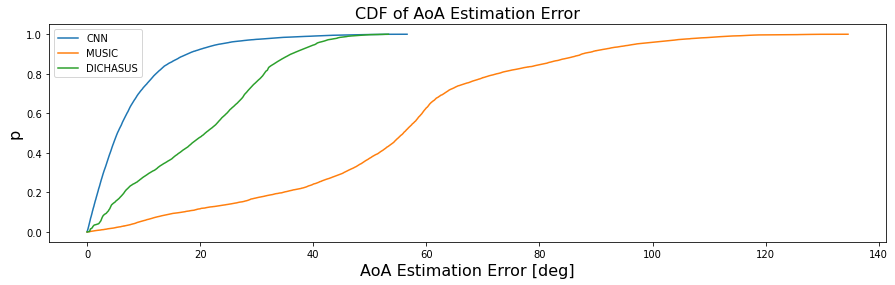

In [18]:
data_sorted = np.sort(errors_abs_deg)

# calculate the proportional values of samples
p = 1. * np.arange(len(data_sorted)) / (len(data_sorted) - 1)

data_sorted_ML = np.sort(errors_abs_deg2)

# calculate the proportional values of samples
p_ml = 1. * np.arange(len(data_sorted_ML)) / (len(data_sorted_ML) - 1)

data_sorted_DICHACUS = np.sort(tmp_error_abs_degrees)
p_d = 1. * np.arange(len(data_sorted_DICHACUS)) / (len(data_sorted_DICHACUS) - 1)

plt.figure(figsize=(15, 4))
plt.title("CDF of AoA Estimation Error", fontsize = 16)
plt.xlabel("AoA Estimation Error [deg]", fontsize = 16)
plt.ylabel("p", fontsize = 16)
		
plt.plot(data_sorted, p, label = "CNN")
plt.plot(data_sorted_ML, p_ml, label = "MUSIC")
plt.plot(data_sorted_DICHACUS, p_d, label = "DICHASUS")
plt.legend()
plt.show()